# Week 3: Lab Assignment - REINFORCE for CartPole


## Objectives

In this lab, you will:
1. Understand the policy network architecture
2. Implement action selection from a stochastic policy
3. Compute discounted returns
4. Implement the REINFORCE policy gradient loss
5. (Optional) Add a baseline for variance reduction

## The CartPole Task

**Goal:** Balance a pole on a moving cart for as long as possible

**State (4 values):**
- Cart position
- Cart velocity
- Pole angle
- Pole angular velocity

**Actions (2 discrete):**
- 0: Push left
- 1: Push right

**Reward:** +1 for each timestep the pole stays up

**Success:** Average reward ≥ 475 over 100 episodes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from matplotlib import animation
from IPython.display import HTML

np.random.seed(42)
torch.manual_seed(42)

---

## Task 1: Understanding the Policy Network

The policy network maps states to action probabilities.

**Architecture:**
```
State (4) → Hidden Layer (32) → Action Logits (2)
              with ReLU             then Softmax
```

### Task 1.1: Complete the Network Architecture

Fill in the missing activation function and hidden dimension.

In [3]:
class PolicyNetwork(nn.Module):
    """Neural network policy for CartPole."""
    
    def __init__(self, state_dim=4, action_dim=2):
        super().__init__()
        
        # ============================================
        # TODO: Set the hidden layer dimension
        # Suggested: 32 neurons
        # ============================================
        hidden_dim = 32  # Replace with a number
        
        # ============================================
        # TODO: Fill in the activation function
        # Use nn.ReLU()
        # ============================================
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),  # Replace with activation function
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, state):
        """Forward pass: state → action logits."""
        return self.network(state)


# Test your network
policy = PolicyNetwork()
test_state = torch.FloatTensor([0.0, 0.0, 0.1, 0.0])
logits = policy(test_state)

print(f"Input state shape: {test_state.shape}")
print(f"Output logits shape: {logits.shape}")
print(f"Output logits: {logits}")

if logits.shape[0] == 2:
    print("\n✓ Network architecture looks correct!")
else:
    print("\n⚠️  Check your network architecture")

Input state shape: torch.Size([4])
Output logits shape: torch.Size([2])
Output logits: tensor([-0.1718,  0.1225], grad_fn=<ViewBackward0>)

✓ Network architecture looks correct!


---

## Task 2: Action Selection

The policy must:
1. Convert logits to probabilities using softmax
2. Sample an action from the probability distribution
3. Return the action and its log probability (for gradient computation)

### Task 2.1: Implement Action Sampling

Complete the `select_action` method.

In [45]:
class PolicyNetwork(nn.Module):
    """Neural network policy for CartPole."""
    
    def __init__(self, state_dim=4, action_dim=2):
        super().__init__()
        hidden_dim = 32
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, state):
        """Forward pass: state → action logits."""
        return self.network(state)
    
    def select_action(self, state):
        """
        Sample an action from the policy.
        
        Args:
            state: numpy array of shape (state_dim,)
        
        Returns:
            action: integer (0 or 1)
            log_prob: tensor containing log probability of the action
        """
        # Convert state to tensor
        state = torch.FloatTensor(state)
        
        # Get action logits from network
        logits = self.forward(state)
        
        # ============================================
        # TODO: Convert logits to probabilities
        # Use torch.softmax(logits, dim=-1)
        # ============================================
        probs = torch.softmax(logits, dim=-1)  # Replace with softmax of logits
        
        # ============================================
        # TODO: Sample an action from the probability distribution
        # Use torch.multinomial(probs, 1).item()
        # ============================================
        action = torch.multinomial(probs, 1).item()  # Replace with sampled action
        
        # Compute log probability of the selected action
        log_prob = torch.log(probs[action])
        
        return action, log_prob


# Test your implementation
policy = PolicyNetwork()
test_state = np.array([0.0, 0.0, 0.1, 0.0])

print("Testing action selection:")
for i in range(5):
    action, log_prob = policy.select_action(test_state)
    print(f"  Trial {i+1}: action={action}, log_prob={log_prob.item():.3f}")

print("\n✓ If you see actions (0 or 1) and log probabilities (negative numbers), it's working!")

Testing action selection:
  Trial 1: action=0, log_prob=-0.583
  Trial 2: action=1, log_prob=-0.817
  Trial 3: action=1, log_prob=-0.817
  Trial 4: action=0, log_prob=-0.583
  Trial 5: action=0, log_prob=-0.583

✓ If you see actions (0 or 1) and log probabilities (negative numbers), it's working!


---

## Task 3: Computing Discounted Returns

The return G_t is the total discounted reward from timestep t:

$$G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... = \sum_{k=0}^{T-t} \gamma^k r_{t+k}$$

**Efficient computation:** Work backwards from the end:
```
G_T = r_T
G_{T-1} = r_{T-1} + γ * G_T
G_{T-2} = r_{T-2} + γ * G_{T-1}
...
```

### Task 3.1: Implement the Return Calculation

This is the **key concept** of REINFORCE!

In [40]:
def compute_returns(rewards, gamma=0.99):
    """
    Compute discounted returns for each timestep.
    
    Args:
        rewards: list of rewards [r_0, r_1, ..., r_T]
        gamma: discount factor
    
    Returns:
        returns: tensor of returns [G_0, G_1, ..., G_T]
    """
    returns = []
    R = 0  # Running return
    
    # ============================================
    # TODO: Compute returns by iterating backwards through rewards
    # For each reward r (starting from the end):
    #   1. Update R = r + gamma * R
    #   2. Insert R at the beginning of returns list
    # 
    # Hint: Use reversed(rewards) to iterate backwards
    # Hint: Use returns.insert(0, R) to insert at beginning
    # ============================================
    
    # Your code here (2-3 lines)
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    return torch.FloatTensor(returns)


# Test your implementation
test_rewards = [1, 1, 1, 1, 1]  # 5 timesteps, reward=1 each
test_gamma = 0.9

returns = compute_returns(test_rewards, test_gamma)

print(f"Rewards: {test_rewards}")
print(f"Gamma: {test_gamma}")
print(f"\nComputed returns: {returns}")

# Expected (working backwards):
# G_4 = 1
# G_3 = 1 + 0.9 * 1 = 1.9
# G_2 = 1 + 0.9 * 1.9 = 2.71
# G_1 = 1 + 0.9 * 2.71 = 3.439
# G_0 = 1 + 0.9 * 3.439 = 4.0951

expected = torch.FloatTensor([4.0951, 3.439, 2.71, 1.9, 1.0])
if torch.allclose(returns, expected, atol=0.01):
    print("\n✓ Correct! Your returns match the expected values.")
else:
    print(f"\n⚠️  Expected approximately: {expected}")
    print("Check your loop implementation.")

Rewards: [1, 1, 1, 1, 1]
Gamma: 0.9

Computed returns: tensor([4.0951, 3.4390, 2.7100, 1.9000, 1.0000])

✓ Correct! Your returns match the expected values.


---

## Task 4: Policy Gradient Loss

The REINFORCE loss is:

$$L = -\sum_{t=0}^T \log \pi_\theta(a_t|s_t) \cdot G_t$$

**Intuition:**
- If G_t is high (good outcome) → increase log π(a_t|s_t) → increase P(a_t|s_t)
- If G_t is low (bad outcome) → decrease log π(a_t|s_t) → decrease P(a_t|s_t)
- The negative sign is because we minimize loss (= maximize reward)

### Task 4.1: Implement the Loss Function

This connects actions to outcomes!

In [41]:
def compute_policy_loss(log_probs, returns):
    """
    Compute REINFORCE policy gradient loss.
    
    Args:
        log_probs: list of log probabilities for each action
        returns: tensor of returns for each timestep
    
    Returns:
        loss: scalar tensor
    """
    # ============================================
    # TODO: Compute the policy gradient loss
    # 
    # For each timestep t:
    #   loss += -log_probs[t] * returns[t]
    # 
    # Hint: You can use a loop, or use:
    #   torch.stack(log_probs) to convert list to tensor
    #   then multiply element-wise and sum
    # ============================================
    
    loss = 0
    # Your code here (1-3 lines)
    for log_prob, R in zip(log_probs, returns):
        loss += -log_prob * R
    
    
    return loss


# Test your implementation
test_log_probs = [
    torch.tensor(-0.5),
    torch.tensor(-0.7),
    torch.tensor(-0.6)
]
test_returns = torch.FloatTensor([3.0, 2.0, 1.0])

loss = compute_policy_loss(test_log_probs, test_returns)

print(f"Log probs: {[lp.item() for lp in test_log_probs]}")
print(f"Returns: {test_returns.tolist()}")
print(f"\nComputed loss: {loss.item():.3f}")

# Expected: -(-0.5*3.0 + -0.7*2.0 + -0.6*1.0) = -(-1.5 - 1.4 - 0.6) = 3.5
expected_loss = 3.5
if abs(loss.item() - expected_loss) < 0.01:
    print(f"\n✓ Correct! Loss = {expected_loss}")
else:
    print(f"\n⚠️  Expected loss ≈ {expected_loss}")
    print("Check your loss calculation.")

Log probs: [-0.5, -0.699999988079071, -0.6000000238418579]
Returns: [3.0, 2.0, 1.0]

Computed loss: 3.500

✓ Correct! Loss = 3.5


---

## Putting It All Together: Training Loop

Now we'll use your implementations to train the agent!

The training loop is provided - it uses all the functions you implemented above.

In [46]:
def train_reinforce(env, policy, optimizer, n_episodes=1000, gamma=0.99):
    """
    Train policy using REINFORCE algorithm.
    
    This function uses your implementations of:
    - policy.select_action()
    - compute_returns()
    - compute_policy_loss()
    """
    episode_rewards = []
    
    for episode in range(n_episodes):
        # Sample an episode
        log_probs = []
        rewards = []
        
        state, _ = env.reset()
        done = False
        
        while not done:
            # Select action using your implementation
            action, log_prob = policy.select_action(state)
            
            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
        
        # Compute returns using your implementation
        returns = compute_returns(rewards, gamma)
        
        # Normalize returns (variance reduction)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Compute loss using your implementation
        loss = compute_policy_loss(log_probs, returns)
        
        # Update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track performance
        episode_rewards.append(sum(rewards))
        
        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}")
    
    return episode_rewards


# Create environment and policy
n_episodes = 500
env_name = 'CartPole-v1'
env = gym.make(env_name)
policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=0.01)

print(f"Training REINFORCE on {env_name}...\n")
rewards = train_reinforce(env, policy, optimizer, n_episodes)

print(f"\nFinal 100-episode average: {np.mean(rewards[-100:]):.2f}")
if np.mean(rewards[-100:]) >= 475:
    print("🎉 SUCCESS! Agent has solved CartPole!")
else:
    print("Keep training or try adjusting hyperparameters.")

Training REINFORCE on CartPole-v1...

Episode 100: Avg Reward = 38.08
Episode 200: Avg Reward = 339.86
Episode 300: Avg Reward = 417.91
Episode 400: Avg Reward = 445.48
Episode 500: Avg Reward = 494.95

Final 100-episode average: 494.95
🎉 SUCCESS! Agent has solved CartPole!


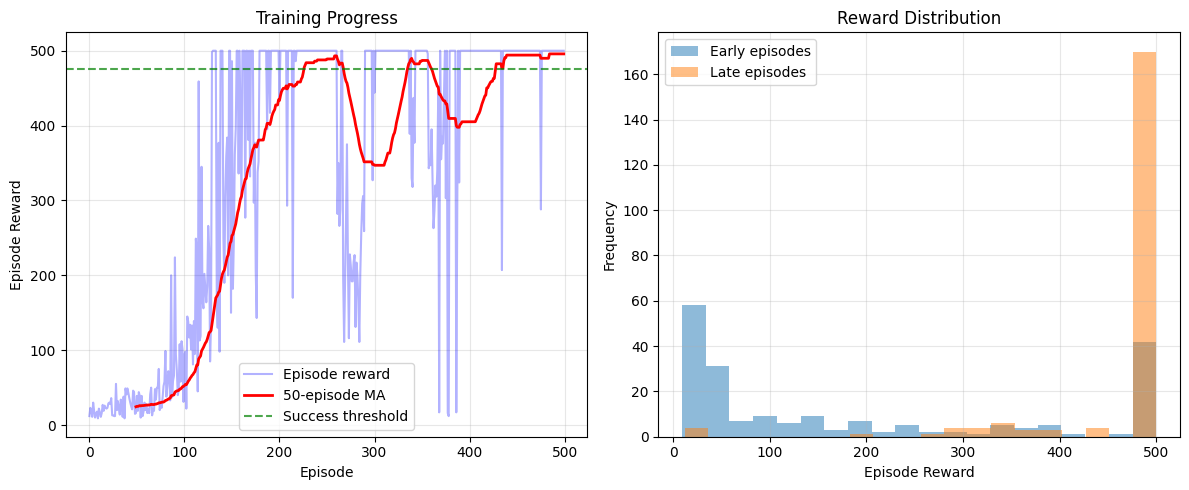

In [47]:
# Plot learning curve
plt.figure(figsize=(12, 5))

# Raw rewards
plt.subplot(1, 2, 1)
plt.plot(rewards, alpha=0.3, color='blue', label='Episode reward')

# Moving average
window = 50
if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(rewards)), moving_avg, color='red', linewidth=2, label=f'{window}-episode MA')

plt.axhline(y=475, color='g', linestyle='--', alpha=0.7, label='Success threshold')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Reward distribution
plt.subplot(1, 2, 2)
early_rewards = rewards[:min(200, len(rewards)//2)]
late_rewards = rewards[max(len(rewards)//2, len(rewards)-200):]

plt.hist(early_rewards, bins=20, alpha=0.5, label=f'Early episodes')
plt.hist(late_rewards, bins=20, alpha=0.5, label=f'Late episodes')
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('Reward Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Visualizing the Trained Agent

Let's watch your trained agent in action!

In [48]:
def display_episode(env, policy, max_steps=500):
    """Record and display an episode."""
    frames = []
    state, _ = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        # Render
        frame = env.render()
        frames.append(frame)
        
        # Select action (greedy)
        state_tensor = torch.FloatTensor(state)
        with torch.no_grad():
            logits = policy(state_tensor)
            probs = torch.softmax(logits, dim=-1)
            action = torch.argmax(probs).item()
        
        # Step
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        
        if terminated or truncated:
            print(f"Episode finished. Terminated: {terminated}, Truncated: {truncated}")
    
    env.close()
    
    print(f"Episode lasted {step + 1} steps, total reward: {total_reward}")
    
    # Create animation
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis('off')
    img = ax.imshow(frames[0])
    
    def animate(i):
        img.set_data(frames[i])
        return [img]
    
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=20, blit=True)
    plt.close()
    
    return HTML(anim.to_html5_video())


# Display trained policy
env = gym.make(env_name, render_mode='rgb_array')
display_episode(env, policy)

Episode finished. Terminated: False, Truncated: True
Episode lasted 500 steps, total reward: 500.0


---

## Task 5 (Optional): Add a Better Baseline

We used return normalization (subtracting mean) as a simple baseline. This reduces variance but we can do better!

**Better baseline:** Use a value network V(s) that estimates the expected return from each state.

**New loss:**
$$L = -\sum_{t=0}^T \log \pi_\theta(a_t|s_t) \cdot (G_t - V_\phi(s_t))$$

This is a preview of **Actor-Critic** (next week)!

### Task 5.1: Implement a Value Network

In [49]:
class ValueNetwork(nn.Module):
    """Value network for estimating V(s)."""
    
    def __init__(self, state_dim=4, hidden_dim=32):
        super().__init__()
        
        # ============================================
        # TODO: Create a network that outputs a single value
        # Architecture: state_dim → hidden_dim (ReLU) → 1
        # ============================================
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, state):
        """Estimate value of state."""
        return self.network(state).squeeze()


def train_with_value_baseline(env, policy, value_net, policy_opt, value_opt, n_episodes=1000, gamma=0.99):
    """Train with learned value baseline."""
    episode_rewards = []
    
    for episode in range(n_episodes):
        states = []
        log_probs = []
        rewards = []
        values = []
        
        state, _ = env.reset()
        done = False
        
        while not done:
            state_tensor = torch.FloatTensor(state)
            
            # ============================================
            # TODO: Get value estimate for current state
            # ============================================
            value = value_net(state_tensor)
            
            action, log_prob = policy.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            states.append(state_tensor)
            log_probs.append(log_prob)
            rewards.append(reward)
            values.append(value)
            state = next_state
        
        # Compute returns
        returns = compute_returns(rewards, gamma)
        
        # ============================================
        # TODO: Compute advantages (returns - values)
        # ============================================
        values_tensor = torch.stack(values)
        advantages = returns - values_tensor.detach()
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # ============================================
        # TODO: Update policy using advantages instead of returns
        # ============================================
        policy_loss = compute_policy_loss(log_probs, advantages)
        
        policy_opt.zero_grad()
        policy_loss.backward()
        policy_opt.step()
        
        # ============================================
        # TODO: Update value network to predict returns better
        # Use MSE loss: (values - returns)^2
        # ============================================
        value_loss = ((values_tensor - returns) ** 2).mean()
        
        value_opt.zero_grad()
        value_loss.backward()
        value_opt.step()
        
        episode_rewards.append(sum(rewards))
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}")
    
    return episode_rewards


# Uncomment to train with value baseline:
env = gym.make('CartPole-v1')
policy = PolicyNetwork()
value_net = ValueNetwork()
policy_opt = optim.Adam(policy.parameters(), lr=0.01)
value_opt = optim.Adam(value_net.parameters(), lr=0.01)

print("Training with value baseline...\n")
rewards_baseline = train_with_value_baseline(env, policy, value_net, policy_opt, value_opt, n_episodes=1000)

Training with value baseline...

Episode 100: Avg Reward = 36.28
Episode 200: Avg Reward = 210.79
Episode 300: Avg Reward = 250.48
Episode 400: Avg Reward = 450.97
Episode 500: Avg Reward = 398.26
Episode 600: Avg Reward = 491.53
Episode 700: Avg Reward = 500.00
Episode 800: Avg Reward = 451.10
Episode 900: Avg Reward = 479.44
Episode 1000: Avg Reward = 423.79


---

## 🎉 Congratulations!

You've successfully:
- Built a policy network
- Implemented action sampling
- Computed discounted returns
- Implemented the REINFORCE algorithm
- Trained an agent to solve CartPole!

### Key Takeaways

1. **Policy gradients** directly optimize the policy π_θ(a|s)
2. **Returns** assign credit to actions based on future outcomes
3. **Stochastic policies** are crucial for exploration
4. **Variance reduction** (baselines) improves learning stability

### What's Next?

**Next week:** Actor-Critic methods
- Combine policy gradient with value function
- Bootstrap instead of Monte Carlo
- Lower variance, faster learning

**Try at home:**
- Run the standalone Python script (see README)
- Experiment with hyperparameters
- Try other gym environments (MountainCar, LunarLander)